Osnabrück University - Computer Vision (Winter Term 2024/25) - Dr. Ulf Krumnack, Lukas Niehaus, Robin Rawiel

# Exercise Sheet 04: Color and segmentation

## Introduction

This week's sheet should be solved and handed in before the end of **Monay, December 9th, 2024**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (the exponential function) [0 Points]

This exercise is supposed to be basic (but maybe less familiar than the last one), does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up (again). You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an *exponential function*? How can it be characterized? What is special about $e^x$?

YOUR ANSWER HERE

**b)** How is the exponential function defined for complex arguments? In what way(s) does this generalize the real case?

YOUR ANSWER HERE

**c)** The complex exponential function allows to define a mapping $\mathbb{R}\to\mathbb{C}$ by $x\mapsto e^{ix}$? How does the graph of this mapping look like? Where are the points $e^{2\pi i\frac mn}$ for $m=0,...,n\in\mathbb{N}$ located on this graph?

YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Assignment 1: Implementation: Skeletonization (5 points)

### a) Skeletonization with hit-or-miss

Explain in your own words, how the hit-or-miss operator can be used for skeletonization (cf CV-05 slide 39).  

Iteratively, 8(one along each direction) hit or miss operator can be used on an distance transformed image to detect and remove the border. After each iteration the border keeps getting eroded until we are left with the final skeleton

### b) Implementation of skeletonization

Now use this method to implement your own skeletonization function. It is ok to use
`scipy.ndimage.morphology.binary_hit_or_miss` here (but of course *not* `skimage.morphology.skeletonize` or similar functions). Compare your result with (CV-05 slide 40). Note that computing the skeleton using this method may take some time ...

In [ ]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_hit_or_miss, distance_transform_cdt, binary_dilation
from imageio.v3 import imread

def my_skeletonize(img):
    skeleton = np.zeros_like(img, dtype=bool)
    structuring_elements = [
        # Horizontal line
        np.array([[0, 1, 0],
                  [0, 1, 0],
                  [0, 0, 0]]),
        
        # Vertical line
        np.array([[0, 0, 0],
                  [1, 1, 0],
                  [0, 0, 0]]),
        
        # Diagonal line (top-left to bottom-right)
        np.array([[0, 0, 1],
                  [0, 1, 0],
                  [1, 0, 0]]),
        
        # Diagonal line (top-right to bottom-left)
        np.array([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
    ]
    
    while img.any():  # Continue until the image is fully eroded
        for se in structuring_elements:
            hit_miss = binary_hit_or_miss(img, structure1=se)
            skeleton |= hit_miss  # Add to the skeleton
        img &= ~skeleton  # Remove the skeletonized parts from the image
    
    return skeleton



img = imread("images/engelstrompete.png") > 0
skel = my_skeletonize(img)
result = distance_transform_cdt(img, metric='taxicab') + (50 * img)
result[binary_dilation(skel)] = 0
plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(result)
plt.show()

## Assignment 2: Hough transform (5 points)

**a)** Explain in your own words the idea of Hough transform in general. What is an accumulator space? In what sense can the Hough transform be seen as a model-based approach?

Hough transform is used to detect geomentric shapes in an image. Shapes in image can be described by geometric formulas like line -> y=mx+c or r=xcos0 + ycos0. Hough tranform transfers a pixel coordinate so that it can be mapped to a parametric space. The shapes can be identified by high clustering or peak in this space.
Accumaltor space is multidimensional space used to represent the shapes. It is multimodal because it relies on mathematical modal to map the shapes. Ex r=xcos0 + ysin0

**b)** What is linear Hough transform? What does a point in the linear Hough space represent? Explain the meaning of the two coordinates.

Linear hugh transform is used to identify straight line in an image by the application of hugh transform. It relies on the model  r=xcos0 + ysin0. A point in Hough space represents a unique line and it lies on a sinusoidal curve. A point P(r,0) means that the perpendicular distance of the line from origin is r and 0 is the angle of its normal with x axis.

**c)**  How are points, lines, polygons transformed by linear Hough transform? What about parallel lines? Try different configurations using the functions `point`, `line`, `polygon` below. Use the function `skimage.transform.hough_line` to display these examples. 
<!-- You may use the code of Assignment 2 to check different configurations interactively. -->

YOUR ANSWER HERE

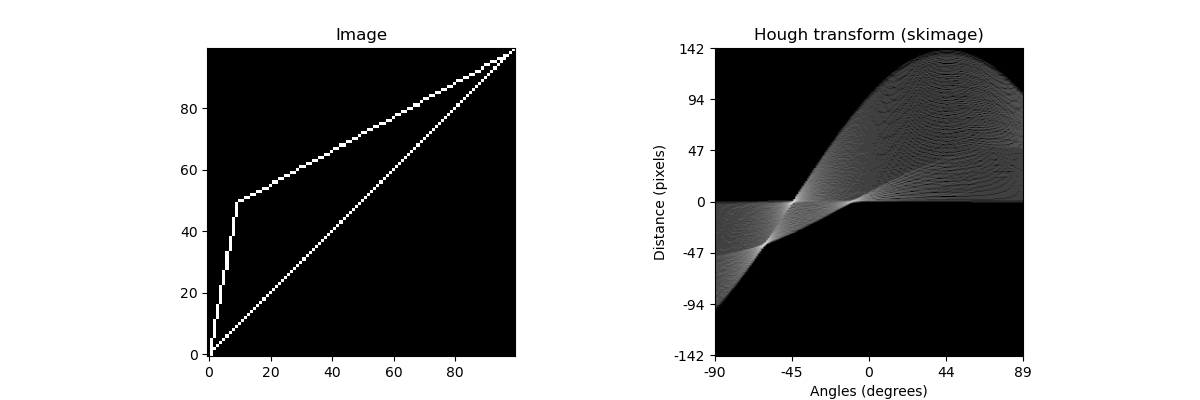

In [12]:
from skimage.transform import hough_line, resize
import matplotlib.pyplot as plt
%matplotlib ipympl
import numpy as np

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])

def point(img, p):
    """Insert a point in the black/white image at position p
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of point.
    
    Returns:
    
    """
    img[p] = 1

def line(img, p, q):
    """Insert a line from p to q in the black/white image
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of start position.
        q (tuple): Coordinate of end position.
    
    Returns:
    
    """
    img[coords(p,q,steps(p,q))] = 1

def polygon(img, vertices):
    """Insert a (closed) polygon given by a list of points into the black/white image
    
    Args:
        img (ndarray): Input image.
        vertices (list): List of coordinate tuples.
    
    Returns:
    
    """
    for p, q in zip(vertices, vertices[1:]+vertices[0:1]):
        line(img,p,q)

img = np.zeros((100,100))
polygon(img,[(0,1),(99,99),(50,10)])
# line(img,(0,1),(99,99))
# point(img,(50,10))

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,4))

plt.gray()
ax1.set_title('Image'); 
ax1.imshow(img, origin = 'lower')

out, angles, d = hough_line(img)

# scale output to quadratic image
out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
ax2.set_title('Hough transform (skimage)');
ax2.set_xlabel('Angles (degrees)')
ax2.set_ylabel('Distance (pixels)')
ax2.imshow(np.log(1 + out_resized), origin = 'lower', cmap='gray')

ax2.set_yticks(np.linspace(0, out.shape[0], 7))
ax2.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax2.set_xticks(np.linspace(0, out.shape[0], 5))
ax2.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))


plt.show()

**d)** The following code block implements an interactive Hough transform, in which you can either draw points or lines and can see the resulting Hough transform immediately. Draw different shapes of points or lines and check the resulting Hough transform. Try to predict the outcome of the transformation!

In [ ]:
%matplotlib ipympl
from skimage.transform import hough_line, resize
import matplotlib.pyplot as plt
import numpy as np

# True if two mouse clicks should draw a line, false if single clicks draw points
lines = True

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])
img = np.zeros((200,200))


def line(img, p, q):
    """Insert a line from p to q in the black/white image
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of start position.
        q (tuple): Coordinate of end position.
    
    Returns:
    
    """
    img[coords(p,q,steps(p,q))] = 1
    

def disp_and_comp():
    """Computes Line Hough transform; displays image and result
    
    Args:
    
    Returns:
    
    """
    ax1.imshow(img, origin = 'lower', cmap='gray')
    
    out, angles, d = hough_line(img)
    
    out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
    ax2.imshow(np.log(1 + out_resized), origin = 'lower', cmap='gray')
    ax2.set_yticks(np.linspace(0, out.shape[0], 7))
    ax2.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
    ax2.set_xticks(np.linspace(0, out.shape[0], 5))
    ax2.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))
    
    fig.canvas.draw()

    
first_point = True
p1 = (0,0)
def on_press(event):
    """Draws either line or point and calls disp_and_comp
    
    Reacts to mouse clicks. Draws either point at mouse
    position and computes Hough transform or draws line
    between first and second mouse click and then computes
    hough transfom.
    
    Args:
        event (event): Mouseevent.
    
    Returns:
    
    """
    global p1, first_point
    y = int(event.xdata)
    x = int(event.ydata)
    
    if (lines):
        if (first_point):
            p1 = (x,y)
            img[x, y] = 255
            first_point = False
        else:
            line(img,p1,(x,y)) 
            first_point = True
        disp_and_comp()
    else:
        img[x, y] = 255
        disp_and_comp()   

fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(121)
plt.title('Image')

ax2 = fig.add_subplot(122)
plt.title('Hough transform');
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.tight_layout()
plt.axis('square')

disp_and_comp()
cnc = fig.canvas.mpl_connect('button_press_event', on_press)

# YOUR CODE HERE
raise NotImplementedError()

## Assignment 3: Implementing Hough transform (5 points)

In [ ]:
# Auxiliary functions for this exercise
import numpy as np
from skimage.transform import hough_line, resize

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])

def point(img, p):
    """Insert a point in the black/white image at position p
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of point.
    
    Returns:
    
    """
    img[p] = 1

def line(img, p, q):
    """Insert a line from p to q in the black/white image
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of start position.
        q (tuple): Coordinate of end position.
    
    Returns:
    
    """
    img[coords(p,q,steps(p,q))] = 1

def polygon(img, vertices):
    """Insert a (closed) polygon given by a list of points into the black/white image
    
    Args:
        img (ndarray): Input image.
        vertices (list): List of coordinate tuples.
    
    Returns:
    
    """
    for p, q in zip(vertices, vertices[1:]+vertices[0:1]):
        line(img,p,q)

**a)** Implement your own version of linear Hough transform and compare the results with the function `skimage.transform.hough_line`.

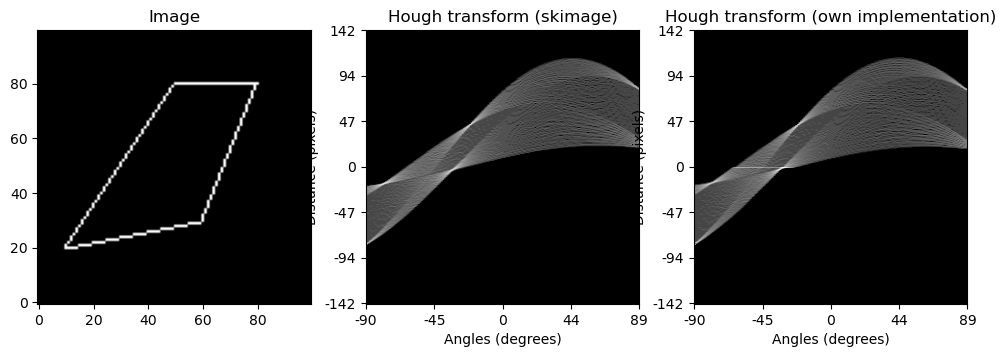

In [32]:
from skimage.transform import hough_line
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def my_hough_line(img, angles=180):
    x_axis = np.linspace(-np.pi/2, np.pi/2, angles) 
    diag_len = int(np.sqrt(img.shape[0]**2 + img.shape[1]**2))  
    y_axis = np.linspace(-diag_len, diag_len, 2 * diag_len) 

    accumulator = np.zeros((len(y_axis), len(x_axis)), dtype=np.int32)

    edge_points = np.argwhere(img > 0) 

    for y, x in edge_points:
        for angle_idx, angle in enumerate(x_axis):
            r = int(x * np.cos(angle) + y * np.sin(angle))  
            r_idx = np.argmin(np.abs(y_axis - r)) 
            accumulator[r_idx, angle_idx] += 1 
    return accumulator


img = np.zeros((100,100))

# You may try different paintings here:
#point(img, (10,10))
#line(img,(10,20),(70,20))
polygon(img,[(20,10),(80,50),(80,80),(30,60)])


fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(12,4))
plt.gray()

# original image
ax1.set_title('Image'); 
ax1.imshow(img, origin = 'lower')

# skimage
out, angles, d = hough_line(img)

out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
ax2.set_title('Hough transform (skimage)');
ax2.set_xlabel('Angles (degrees)')
ax2.set_ylabel('Distance (pixels)')
ax2.imshow(np.log(1 + out_resized), origin = 'lower', cmap='gray')
ax2.set_yticks(np.linspace(0, out.shape[0], 7))
ax2.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax2.set_xticks(np.linspace(0, out.shape[0], 5))
ax2.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

# own implementation
my_out = my_hough_line(img)

my_out_resized = resize(my_out, (my_out.shape[0], my_out.shape[0]), anti_aliasing=True, preserve_range=True)
ax3.set_title('Hough transform (own implementation)');
ax3.set_xlabel('Angles (degrees)')
ax3.set_ylabel('Distance (pixels)')
ax3.imshow(np.log(1 + my_out_resized), origin = 'lower', cmap='gray')
ax3.set_yticks(np.linspace(0, my_out.shape[0], 7))
ax3.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax3.set_xticks(np.linspace(0, my_out.shape[0], 5))
ax3.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

plt.show()

**b)** Under which conditions is (linear) Hough transform invertible? Try to implement an inverse linear Hough transform. 

You could create a line for each point in accumulator space by doing the following: Compute angle and distance of the line represented by the current point in accumulator space. Add the value of this point to all image pixels which belong to the corresponding line. Finally you could threshold the image. 

However, other solution are feasible, too.


No overlapping lines or complex figures
Accumulator must have all the information

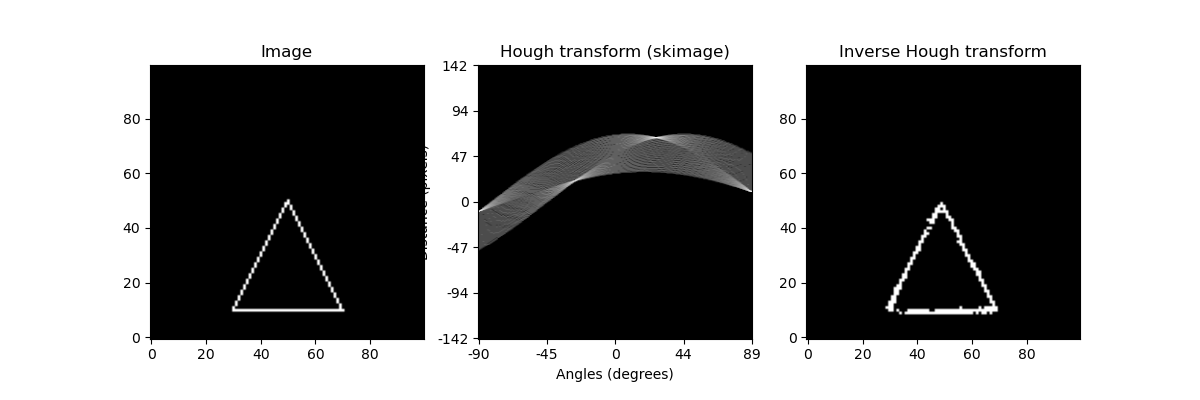

In [47]:
%matplotlib ipympl 
from skimage.transform import hough_line
import matplotlib.pyplot as plt
import numpy as np

import numpy as np

def my_inverse_hough_line(accumulator, shape):
    """
    Reconstruct an image from the Hough accumulator space by drawing lines corresponding to the peaks.

    Args:
        accumulator (numpy.ndarray): The Hough accumulator space.
        shape (tuple): Shape of the output image (height, width).

    Returns:
        img (numpy.ndarray): Reconstructed image with lines.
    """
    img = np.zeros(shape, dtype=np.float32)

    # Define theta and rho ranges
    theta_range = np.linspace(-np.pi / 2, np.pi / 2, accumulator.shape[1])
    diag_len = int(np.sqrt(shape[0]**2 + shape[1]**2))
    rho_range = np.linspace(-diag_len, diag_len, accumulator.shape[0])

    # Loop through each point in the accumulator space
    for r_idx in range(accumulator.shape[0]):
        for theta_idx in range(accumulator.shape[1]):
            val = accumulator[r_idx, theta_idx]
            if val > 0: 
                rho = rho_range[r_idx]
                theta = theta_range[theta_idx]

                cos_theta = np.cos(theta)
                sin_theta = np.sin(theta)

                for x in range(shape[1]):  
                    y = int((rho - x * cos_theta) / sin_theta)
                    if 0 <= y < shape[0]: 
                        img[y, x] += val  

                for y in range(shape[0]): 
                    x = int((rho - y * sin_theta) / cos_theta)
                    if 0 <= x < shape[1]:  
                        img[y, x] += val  

    img = (img > np.max(img) * 0.75).astype(np.bool)   

    return img

img = np.zeros((100,100))

#point(img, (10,10))
#line(img,(10,20),(70,20))
#line(img,(20,10),(20,70))
polygon(img,[(10,30),(50,50),(10,70)])

plt.figure(figsize=(12, 4))
plt.gray()
plt.subplot(1,3,1) ; plt.title('Image'); plt.imshow(img, origin = 'lower')

out, angles, d = hough_line(img)
out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
ax = plt.subplot(1,3,2) ; plt.title('Hough transform (skimage)');
ax.set_title('Hough transform (skimage)');
ax.set_xlabel('Angles (degrees)')
ax.set_ylabel('Distance (pixels)')
ax.imshow(np.log(1 + out_resized), origin = 'lower', cmap='gray')
ax.set_yticks(np.linspace(0, out.shape[0], 7))
ax.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax.set_xticks(np.linspace(0, out.shape[0], 5))
ax.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

img2 = my_inverse_hough_line(out, img.shape)
plt.subplot(1,3,3) ; plt.title('Inverse Hough transform');
plt.imshow(img2, origin = 'lower')
plt.show()

## Assignment 4: Circular Hough (5 points)

**a)** Explain the idea of circular Hough transform. How many dimensions does the accumulator space have and what do they represent? What practical problems do you expect when computing circular Hough transform?

The circular Hough transform is an extension of the Hough transform used to detect circular shapes in an image. Instead of detecting straight lines (as in the linear Hough transform), the circular Hough transform identifies pixels that align to form circles.
3 dimensions.
Computational complexity

**b)** Now implement circular hough transform. First think how the accumulator space should be represented. You may provide an additional parameter to only look for circles of a given radius (or a range of radii). Then apply it to the image `xmas.png` to detect the balls. Mark them in the original image. (Bonus task: also detect the presents using linear Hough transform).

In [ ]:
%matplotlib ipympl
from skimage.transform import hough_line
from scipy import misc
from imageio.v3 import imread
import matplotlib.pyplot as plt
import numpy as np

# load the image
img = imread('images/xmas.png')

def circular_hough_transform(img, radius_range):
    min_radius, max_radius = radius_range
    rows, cols = img.shape

    accumulator = np.zeros((rows, cols), dtype=np.int32)
    edge_points = np.argwhere(img > 0) 

    for x, y in edge_points:
        for r in range(min_radius, max_radius):
            for theta in np.linspace(0, 2 * np.pi, 360):  
                a = int(x - r * np.cos(theta))
                b = int(y - r * np.sin(theta))

                if 0 <= a < rows and 0 <= b < cols:
                    accumulator[a, b] += 1

    detected_circles = []
    threshold = np.max(accumulator) * 0.7 
    circles = np.argwhere(accumulator > threshold)  

    for a, b in circles:
        detected_circles.append((a, b, r))

    return accumulator, detected_circles

radius_range = (10, 50) 
radii = np.arange(radius_range[0], radius_range[1])
accumulator, circles = circular_hough_transform(img, radius_range)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot original image with detected circles
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

radius_index = len(radii) 
plt.subplot(1, 2, 2)
plt.imshow(accumulator[:, :, radius_index], cmap='hot')
plt.title(f"Accumulator Space (r = {radii[radius_index]})")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()